# 패키지 불러오기

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import os
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import norm
import ruptures as rpt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro

ModuleNotFoundError: No module named 'ruptures'

# 데이터불러오기

In [ ]:
kospi = pd.read_csv('other data/final_kospi.csv')

In [ ]:
csv_files = [file for file in os.listdir() if file.endswith(".csv")]

,Date,종가,시가,고가,저가,거래량,r_m
0,1993-08-12,725.94,725.94,725.94,725.94,14.70M,0.32
1,1993-08-13,693.57,693.57,693.57,693.57,1.36M,-4.46
2,1993-08-14,666.67,666.67,666.67,666.67,21.20M,-3.88
3,1993-08-16,691.67,691.67,691.67,691.67,29.69M,3.75
4,1993-08-17,688.94,688.94,688.94,688.94,25.01M,-0.39
...,...,...,...,...,...,...,...
7214,2021-10-25,"3,020.54","3,001.10","3,025.27","2,983.29",791.80M,0.48
7215,2021-10-26,"3,049.08","3,039.82","3,051.65","3,030.53",564.56M,0.94
7216,2021-10-27,"3,025.49","3,045.83","3,049.02","3,019.00",607.88M,-0.77
7217,2021-10-28,"3,009.55","3,023.17","3,034.42","3,009.55",617.26M,-0.53


# 함수

In [ ]:
#Maximum Drawdown

def calculate_mdd(return_series):
    # 누적 최대값을 계산
    running_max = return_series.expanding(min_periods=1).max()
    # 현재 값과 누적 최대값의 차이(낙폭)를 계산
    drawdown = running_max - return_series
    # 최대 낙폭을 계산
    mdd = drawdown.max()
    return mdd

In [ ]:
def calculate_mdds_over_recovery_time(past_series, recovery_time):
    mdds = []
    for i in range(len(past_series) - recovery_time):
        # recovery_time 구간을 선택하여 MDD 계산
        mdd = calculate_mdd(past_series[i:i+recovery_time+1])
        mdds.append(mdd)
    return mdds

In [ ]:
def calculate_mdds_over_recovery_time2(past_series, recovery_time):
    mdds = []
    for i in range(len(past_series) - recovery_time):
        # recovery_time 구간을 선택하여 MDD 계산
        mdd = calculate_mdd(past_series[i:i+recovery_time+1])
        mdds.append(mdd)

    # 인덱스의 길이와 일치하도록 결과를 반환
    result = np.full(len(past_series), np.nan)
    result[:len(mdds)] = mdds
    return result


# 티커별 다른 회복기간만큼 mdd

In [ ]:
#시장모형
# 빈리스트 생성

result_columns = ['DataName', 'EventDate', 'ResidualVariance', 'R_M_Bar', 'AAR0', 'AAR1', 'AAR5', 'AAR10', 'AAR25', 'CSAR0', 'CSAR1', 'CSAR5', 'CSAR10', 'CSAR25','shapiro_result','var95','var99','mdd']
result_df = pd.DataFrame(columns=result_columns)

for data_path in csv_files:
    try:
        # 데이터불러오기
        df = pd.read_csv(data_path)

        # 일별 수익률 계산
        #df['daily_return'] = np.log(df['Close'])
        df['daily_return'] = df['Close'].diff()

        #누적수익률
        df['cum_return'] = df['daily_return'].cumsum()
        kospi['cum_return'] = kospi['r_m'].cumsum()

        # event_date 날짜형식으로
        date_str = data_path.split("_")[1].split(".")[0]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = date_obj.strftime('%Y-%m-%d')

         #  event_date이 거래일이 아닌 경우 가장 가까운날 랜덤하게 선택
        if event_date not in df['Date'].values:
            nearest_date_idx = (pd.to_datetime(df['Date']) - pd.to_datetime(event_date)).abs().idxmin()
            event_date = df.loc[nearest_date_idx-1, 'Date']

#         # event_date이 거래일이 아닌 경우 다음거래일을 event_date으로 선택
#         if event_date not in df['Date'].values:
#             future_dates = df[df['Date'] > event_date]['Date']
#             nearest_date = future_dates[pd.to_datetime(future_dates).sub(pd.to_datetime(event_date)).abs().idxmin()]
#             event_date = nearest_date


        # 이벤트 날짜의 인덱스 가져오기
        event_index = df[df['Date'] == event_date].index[0]
        post_event_df = df[event_index:]

        # new_date 열 추가
        df['new_date'] = df.index - event_index

        #MDD 계산하기


        #drawdowns
        event_cum_return = df.loc[df['Date'] == event_date, 'cum_return'].iloc[0]
        drawdowns = event_cum_return - post_event_df['cum_return']

        # drawdown이 처음으로 음수가 되는 시점
        first_negative_index = drawdowns.lt(0).idxmax()

        # max drawdown
        mdd = drawdowns.iloc[:first_negative_index-event_index+1].max()
        mdd_index = drawdowns[:first_negative_index - event_index + 1].idxmax()

        # mdd_time: max drawdown이 되는 시점까지의 시간
        mdd_time = mdd_index - event_index

        # recovery까지 시간 계산
        time_to_recovery = first_negative_index - event_index
        #time_to_recovery = 30

        #####overall mdd####


        df['r_i'] = calculate_mdds_over_recovery_time2(df['cum_return'], time_to_recovery)
        kospi['r_mm'] = calculate_mdds_over_recovery_time2(kospi['cum_return'], time_to_recovery)


        # new_date 열 추가
        df['new_date'] = df.index - event_index




        # 선택된 열 추출
        selected_kospi = kospi[['Date','r_mm']]
        selected_df = df[['Date','new_date','r_i']]

        # 날짜 형식 변환
        selected_df['Date'] = pd.to_datetime(selected_df['Date'])
        selected_kospi['Date'] = pd.to_datetime(selected_kospi['Date'])


        # 'kospi_날짜' 및 'Date' 열을 기준으로 조인
        merged_df = pd.merge(selected_df, selected_kospi, how='left', on='Date')


        #train period
        estpd_df = merged_df[(merged_df['new_date'] >= -100) & (merged_df['new_date'] <= -2)]
        #결측값 발생시 최근3개의 평균으로 대체
        #estpd_df['r_m'].fillna(estpd_df['r_m'].rolling(window=3, min_periods=1).mean(), inplace=True)
        #결측값 발생시 누락
        estpd_df = estpd_df.dropna()

        # 회귀분석을 위한 모델 생성
        X = estpd_df[['r_mm']]
        y = estpd_df['r_i']

        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_
        alpha = model.intercept_


        # 잔차(residuals) 추출
        residuals = y - model.predict(X)

        # 잔차의 분산 출력
        residual_variance = residuals.var()

        r_m_bar = estpd_df['r_mm'].mean()

        # 필요한 값 추출
        r_values = {}
        rm_values = {}
        rf_values = {}
        ar_values = {}
        var_ar_values = {}
        sar_values = {}

        for t in range(-1, 26):
            r_t = merged_df.loc[merged_df['new_date'] == t, 'r_i'].values[0]
            r_m_t = merged_df.loc[merged_df['new_date'] == t, 'r_mm'].values[0]
            ar_t = r_t - (alpha + beta * r_m_t)
            var_ar_t = residual_variance * (1 + 1/100 + (r_m_t - r_m_bar)**2 / ((estpd_df['r_mm'] - r_m_bar) ** 2).sum())
            sar_t = ar_t / np.sqrt(var_ar_t)
            r_values[f'r_{t:02d}'] = r_t
            rm_values[f'rm_{t:02d}'] = r_m_t
            ar_values[f'ar_{t:02d}'] = ar_t[0]
            var_ar_values[f'var_ar_{t:02d}'] = var_ar_t
            sar_values[f'sar_{t:02d}'] = sar_t[0]


        #CAR_i
        car0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))
        car1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))
        car5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))
        car10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))
        car25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))

        #AAR_i
        aar0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))/2
        aar1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))/3
        aar5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))/7
        aar10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))/12
        aar25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))/27

        #CSAR_i
        csar0 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 1))/np.sqrt(2)
        csar1 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 2))/np.sqrt(3)
        csar5 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 6))/np.sqrt(7)
        csar10 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 11))/np.sqrt(12)
        csar25 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 26))/np.sqrt(27)


        # Shapiro-Wilk 검정 수행
        statistic, p_value = shapiro(estpd_df['r_i'])

        # 결과를 저장하는 객체 생성
        shapiro_result = 1 if p_value > 0.05 else 0

        #VaR
        var95 = estpd_df['r_i'].quantile(0.95)
        var99 = estpd_df['r_i'].quantile(0.99)


        #Append results to result_df
        result_df = result_df.append({
             'DataName': os.path.basename(data_path),
             'EventDate': event_date,
             'ResidualVariance': residual_variance,
             'R_M_Bar': r_m_bar,
             'AAR0': aar0,
             'AAR1': aar1,
             'AAR5': aar5,
             'AAR10': aar10,
             'AAR25': aar25,
             'CSAR0': csar0,
             'CSAR1': csar1,
             'CSAR5': csar5,
             'CSAR10': csar10,
             'CSAR25': csar25,
             'shapiro_result': shapiro_result,
             'var95': var95,
             'var99': var99,
             'mdd': mdd
         }, ignore_index=True)
    except Exception as e:
        print(f"Error processing {data_path}: {e}")



Error processing kt.csv: 'Close'
Error processing log result.csv: 'Close'


In [ ]:
#검정통계량 계산
sum_csar = result_df['CSAR0'].sum()
n=len(result_df['CSAR0'])-result_df['CSAR0'].isna().sum()
total_csar = sum_csar/n
Z0=np.sqrt(n)*total_csar
print(f'Z0:',round(Z0,4))


#검정통계량 계산
sum_csar = result_df['CSAR1'].sum()
n=len(result_df['CSAR1'])-result_df['CSAR1'].isna().sum()
total_csar = sum_csar/n
Z1=np.sqrt(n)*total_csar
print(f'Z1:', round(Z1,4))

#검정통계량 계산
sum_csar = result_df['CSAR5'].sum()
n=len(result_df['CSAR5'])-result_df['CSAR5'].isna().sum()
total_csar = sum_csar/n
Z5=np.sqrt(n)*total_csar
print(f'Z5:',round(Z5,2))

#검정통계량 계산
sum_csar = result_df['CSAR10'].sum()
n=len(result_df['CSAR10'])-result_df['CSAR10'].isna().sum()
total_csar = sum_csar/n
Z10=np.sqrt(n)*total_csar
print(f'Z10:',round(Z10,4))

#검정통계량 계산
sum_csar = result_df['CSAR25'].sum()
n=len(result_df['CSAR25'])-result_df['CSAR25'].isna().sum()
total_csar = sum_csar/n
Z25=np.sqrt(n)*total_csar
print(f'Z25:',round(Z25,4))



Z0: -2.4716
Z1: -4.4923
Z5: -3.79
Z10: -2.7773
Z25: -1.413


In [ ]:
result_df['shapiro_result'].sum()

13

In [ ]:
result_df

,DataName,EventDate,ResidualVariance,R_M_Bar,AAR0,AAR1,AAR5,AAR10,AAR25,CSAR0,CSAR1,CSAR5,CSAR10,CSAR25,shapiro_result,var95,var99
0,KS000150_20050721.csv,2005-07-21,152426.915871,1.473646,615.533283,690.905698,774.829160,593.165976,NaN,2.206990,3.033621,5.200213,5.212171,NaN,0,1333.263428,NaN
1,KS000270_20030722.csv,2003-07-22,23263.751852,2.195638,19.741177,27.379272,-50.272286,31.459637,NaN,0.181365,0.307518,-0.867174,0.711036,NaN,0,661.000000,NaN
2,KS000270_20040630.csv,2004-06-30,74107.999616,14.445106,-83.232868,-98.820224,NaN,NaN,NaN,-0.428689,-0.622998,NaN,NaN,NaN,0,3270.000000,NaN
3,KS000270_20050817.csv,2005-08-17,174758.038380,2.377684,-781.630376,-798.297043,-815.403723,-613.684759,NaN,-2.608485,-3.262850,-5.096498,-5.028702,NaN,0,2050.000000,NaN
4,KS000270_20060621.csv,2006-06-21,44890.698816,0.568265,-102.637370,-140.388378,-111.396452,-68.933046,-33.573587,-0.680381,-1.140683,-1.382728,-1.119610,-0.823465,0,650.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,KS105560_20141027.csv,2014-10-27,123077.696708,0.258687,-156.851405,-133.892472,46.932562,109.111852,106.955058,-0.628600,-0.656936,0.349443,1.067529,1.566580,0,905.000000,NaN
191,KS120110_20150429.csv,2015-04-29,663288.844744,0.554737,-56.405544,-355.604228,-231.934835,822.244472,895.765352,-0.082762,-0.672996,-0.662268,3.542628,5.431075,0,3300.000000,NaN
192,KS139130_20191213.csv,2019-12-13,4633.456787,0.621515,29.574365,10.863484,3.078731,38.460370,4.371132,0.610079,0.274580,0.118013,1.942854,0.340026,0,241.000000,NaN
193,KS316140_20200130.csv,2020-01-30,54240.449038,1.250000,-169.173775,-151.397342,-74.084326,-94.902664,-170.716810,-1.014452,-1.113806,-0.833149,-1.400142,-3.533892,0,805.000000,NaN


# Z0 2일

In [ ]:
#시장모형
# 빈리스트 생성

result_columns = ['DataName', 'EventDate', 'ResidualVariance', 'R_M_Bar', 'AAR0', 'AAR1', 'AAR5', 'AAR10', 'AAR25', 'CSAR0', 'CSAR1', 'CSAR5', 'CSAR10', 'CSAR25',
                  'shapiro_result','var95','var99','mdd0']
result_df0 = pd.DataFrame(columns=result_columns)

for data_path in csv_files:
    try:
        # 데이터불러오기
        df = pd.read_csv(data_path)

        # 일별 수익률 계산
        #df['daily_return'] = np.log(df['Close'])
        df['daily_return'] = df['Close'].diff()

        #누적수익률
        df['cum_return'] = df['daily_return'].cumsum()
        kospi['cum_return'] = kospi['r_m'].cumsum()

        # event_date 날짜형식으로
        date_str = data_path.split("_")[1].split(".")[0]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = date_obj.strftime('%Y-%m-%d')

         # event_date이 거래일이 아닌 경우 가장 가까운날 랜덤하게 선택
        if event_date not in df['Date'].values:
            nearest_date_idx = (pd.to_datetime(df['Date']) - pd.to_datetime(event_date)).abs().idxmin()
            event_date = df.loc[nearest_date_idx-1, 'Date']

#         # event_date이 거래일이 아닌 경우 다음거래일을 event_date으로 선택
#         if event_date not in df['Date'].values:
#             future_dates = df[df['Date'] > event_date]['Date']
#             nearest_date = future_dates[pd.to_datetime(future_dates).sub(pd.to_datetime(event_date)).abs().idxmin()]
#             event_date = nearest_date


        # 이벤트 날짜의 인덱스 가져오기
        event_index = df[df['Date'] == event_date].index[0]
        post_event_df = df[event_index:]

        # new_date 열 추가
        df['new_date'] = df.index - event_index

        #MDD 계산하기


#         #drawdowns
#         event_cum_return = df.loc[df['Date'] == event_date, 'cum_return'].iloc[0]
#         drawdowns = event_cum_return - post_event_df['cum_return']

#         # drawdown이 처음으로 음수가 되는 시점
#         first_negative_index = drawdowns.lt(0).idxmax()

#         # max drawdown
#         mdd = drawdowns.iloc[:first_negative_index-event_index+1].max()
#         mdd_index = drawdowns[:first_negative_index - event_index + 1].idxmax()


#         # mdd_time: max drawdown이 되는 시점까지의 시간
#         mdd_time = mdd_index - event_index

#         # recovery까지 시간 계산
#         time_to_recovery = first_negative_index - event_index
#         #time_to_recovery = 30

        #####overall mdd####


        df['r_i'] = calculate_mdds_over_recovery_time2(df['cum_return'], 2)
        kospi['r_mm'] = calculate_mdds_over_recovery_time2(kospi['cum_return'], 2)


        # new_date 열 추가
        df['new_date'] = df.index - event_index


        # 선택된 열 추출
        selected_kospi = kospi[['Date','r_mm']]
        selected_df = df[['Date','new_date','r_i']]

        # 날짜 형식 변환
        selected_df['Date'] = pd.to_datetime(selected_df['Date'])
        selected_kospi['Date'] = pd.to_datetime(selected_kospi['Date'])


        # 'kospi_날짜' 및 'Date' 열을 기준으로 조인
        merged_df = pd.merge(selected_df, selected_kospi, how='left', on='Date')


        #train period
        estpd_df = merged_df[(merged_df['new_date'] >= -100) & (merged_df['new_date'] <= -2)]
        #결측값 발생시 최근3개의 평균으로 대체
        #estpd_df['r_m'].fillna(estpd_df['r_m'].rolling(window=3, min_periods=1).mean(), inplace=True)
        #결측값 발생시 누락
        estpd_df = estpd_df.dropna()

        # 회귀분석을 위한 모델 생성
        X = estpd_df[['r_mm']]
        y = estpd_df['r_i']

        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_
        alpha = model.intercept_


        # 잔차(residuals) 추출
        residuals = y - model.predict(X)

        # 잔차의 분산 출력
        residual_variance = residuals.var()

        r_m_bar = estpd_df['r_mm'].mean()

        # 필요한 값 추출
        r_values = {}
        rm_values = {}
        rf_values = {}
        ar_values = {}
        var_ar_values = {}
        sar_values = {}

        for t in range(-1, 26):
            r_t = merged_df.loc[merged_df['new_date'] == t, 'r_i'].values[0]
            r_m_t = merged_df.loc[merged_df['new_date'] == t, 'r_mm'].values[0]
            ar_t = r_t - (alpha + beta * r_m_t)
            var_ar_t = residual_variance * (1 + 1/100 + (r_m_t - r_m_bar)**2 / ((estpd_df['r_mm'] - r_m_bar) ** 2).sum())
            sar_t = ar_t / np.sqrt(var_ar_t)
            r_values[f'r_{t:02d}'] = r_t
            rm_values[f'rm_{t:02d}'] = r_m_t
            ar_values[f'ar_{t:02d}'] = ar_t[0]
            var_ar_values[f'var_ar_{t:02d}'] = var_ar_t
            sar_values[f'sar_{t:02d}'] = sar_t[0]


        #CAR_i
        car0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))
        car1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))
        car5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))
        car10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))
        car25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))

        #AAR_i
        aar0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))/2
        aar1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))/3
        aar5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))/7
        aar10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))/12
        aar25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))/27

        #CSAR_i
        csar0 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 1))/np.sqrt(2)
        csar1 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 2))/np.sqrt(3)
        csar5 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 6))/np.sqrt(7)
        csar10 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 11))/np.sqrt(12)
        csar25 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 26))/np.sqrt(27)

        # Shapiro-Wilk 검정 수행
        statistic, p_value = shapiro(estpd_df['r_i'])

        # 결과를 저장하는 객체 생성
        shapiro_result = 1 if p_value > 0.05 else 0

        #VaR
        var95 = estpd_df['r_i'].quantile(0.95)
        var99 = estpd_df['r_i'].quantile(0.99)

        selected_rows = df[(df['new_date'] >= -2) & (df['new_date'] <= 0)]
        mdd0 = calculate_mdd(selected_rows['cum_return'].astype(float))

        #Append results to result_df
        result_df0 = result_df0.append({
             'DataName': os.path.basename(data_path),
             'EventDate': event_date,
             'ResidualVariance': residual_variance,
             'R_M_Bar': r_m_bar,
             'AAR0': aar0,
             'AAR1': aar1,
             'AAR5': aar5,
             'AAR10': aar10,
             'AAR25': aar25,
             'CSAR0': csar0,
             'CSAR1': csar1,
             'CSAR5': csar5,
             'CSAR10': csar10,
             'CSAR25': csar25,
             'shapiro_result':shapiro_result,
             'var95': var95,
             'var99': var99,
             'mdd0': mdd0
         }, ignore_index=True)
    except Exception as e:
        print(f"Error processing {data_path}: {e}")



Error processing kt.csv: 'Close'
Error processing log result.csv: 'Close'


In [ ]:
#검정통계량 계산
sum_csar = result_df['CSAR0'].sum()
n=len(result_df['CSAR0'])-result_df['CSAR0'].isna().sum()
total_csar = sum_csar/n
Z0=np.sqrt(n)*total_csar
print(f'Z0:',round(Z0,4))


#검정통계량 계산
sum_csar = result_df['CSAR1'].sum()
n=len(result_df['CSAR1'])-result_df['CSAR1'].isna().sum()
total_csar = sum_csar/n
Z1=np.sqrt(n)*total_csar
print(f'Z1:', round(Z1,4))

#검정통계량 계산
sum_csar = result_df['CSAR5'].sum()
n=len(result_df['CSAR5'])-result_df['CSAR5'].isna().sum()
total_csar = sum_csar/n
Z5=np.sqrt(n)*total_csar
print(f'Z5:',round(Z5,2))

#검정통계량 계산
sum_csar = result_df['CSAR10'].sum()
n=len(result_df['CSAR10'])-result_df['CSAR10'].isna().sum()
total_csar = sum_csar/n
Z10=np.sqrt(n)*total_csar
print(f'Z10:',round(Z10,4))

#검정통계량 계산
sum_csar = result_df['CSAR25'].sum()
n=len(result_df['CSAR25'])-result_df['CSAR25'].isna().sum()
total_csar = sum_csar/n
Z25=np.sqrt(n)*total_csar
print(f'Z25:',round(Z25,4))



Z0: 2.974
Z1: 1.8171
Z5: 0.96
Z10: 1.488
Z25: 1.0429


In [ ]:
result_df0['shapiro_result'].sum()

0

In [ ]:
result_df0

,DataName,EventDate,ResidualVariance,R_M_Bar,AAR0,AAR1,AAR5,AAR10,AAR25,CSAR0,CSAR1,CSAR5,CSAR10,CSAR25,shapiro_result,var95,var99,mdd0
0,KS000150_20050721.csv,2005-07-21,60157.693502,0.660625,827.992508,536.904430,502.694814,374.589655,NaN,4.737653,3.762563,5.380133,5.248641,NaN,0,728.484375,1212.307617,659.75879
1,KS000270_20030722.csv,2003-07-22,14217.441754,1.182021,-2.259039,28.257854,-28.743916,12.104697,NaN,-0.026633,0.406824,-0.635070,0.348526,NaN,0,530.000000,644.200000,300.00000
2,KS000270_20040630.csv,2004-06-30,38344.756792,1.512128,4.165034,36.082408,67.594872,-44.761414,-67.648323,0.027727,0.314803,0.905153,-0.788277,-1.785472,0,667.500000,957.000000,0.00000
3,KS000270_20050817.csv,2005-08-17,43370.498432,0.519263,26.409367,-26.746573,-106.883719,-154.099234,NaN,0.174771,-0.224148,-1.335387,-2.475393,NaN,0,800.000000,1174.000000,50.00000
4,KS000270_20060621.csv,2006-06-21,102553.294541,1.136531,-270.347307,-288.305852,-231.056844,-123.812631,-73.359227,-1.185851,-1.549694,-1.896596,-1.329824,-1.190473,0,1065.000000,1318.000000,500.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,KS105560_20141027.csv,2014-10-27,243363.155556,0.514949,-328.438291,-303.668328,87.601188,205.347024,200.266312,-0.936205,-1.059341,0.466287,1.427621,2.088867,0,1705.000000,2150.000000,0.00000
191,KS120110_20150429.csv,2015-04-29,777026.936231,0.153158,633.829835,10.605509,-408.462045,42.263446,-144.282951,0.878879,0.148192,-0.557994,0.634012,-0.314394,0,2510.000000,2582.000000,1900.00000
192,KS139130_20191213.csv,2019-12-13,4633.456787,0.621515,29.574365,10.863484,3.078731,38.460370,4.371132,0.610079,0.274580,0.118013,1.942854,0.340026,0,241.000000,293.600000,0.00000
193,KS316140_20200130.csv,2020-01-30,21584.941078,0.543737,-85.395387,-76.023185,-46.376408,-43.648392,-99.455615,-0.766577,-0.849309,-0.802828,-1.001810,-3.193222,0,505.000000,601.000000,0.00000


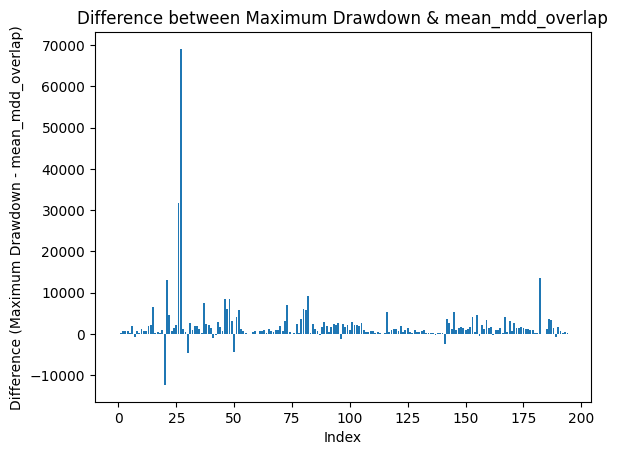

In [ ]:
# 두 열의 크기 차이 계산
difference =  result_df0['var95'] - result_df0['mdd0']

# 바 차트 그리기
plt.bar(result_df0.index, difference)

# 레이블링 및 제목 설정
plt.xlabel('Index')
plt.ylabel('Difference (Maximum Drawdown - mean_mdd_overlap)')
plt.title('Difference between Maximum Drawdown & mean_mdd_overlap')

# 그래프 출력
plt.show()

# Z1 3일

In [ ]:
#시장모형
# 빈리스트 생성

result_columns = ['DataName', 'EventDate', 'ResidualVariance', 'R_M_Bar', 'AAR0', 'AAR1', 'AAR5', 'AAR10', 'AAR25', 'CSAR0', 'CSAR1', 'CSAR5', 'CSAR10', 'CSAR25',
                  'shapiro','var95','var99','mdd1']
result_df1 = pd.DataFrame(columns=result_columns)

for data_path in csv_files:
    try:
        # 데이터불러오기
        df = pd.read_csv(data_path)

        # 일별 수익률 계산
        #df['daily_return'] = np.log(df['Close'])
        df['daily_return'] = df['Close'].diff()

        #누적수익률
        df['cum_return'] = df['daily_return'].cumsum()
        kospi['cum_return'] = kospi['r_m'].cumsum()

        # event_date 날짜형식으로
        date_str = data_path.split("_")[1].split(".")[0]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = date_obj.strftime('%Y-%m-%d')

         #  event_date이 거래일이 아닌 경우 가장 가까운날 랜덤하게 선택
        if event_date not in df['Date'].values:
            nearest_date_idx = (pd.to_datetime(df['Date']) - pd.to_datetime(event_date)).abs().idxmin()
            event_date = df.loc[nearest_date_idx-1, 'Date']

#         # event_date이 거래일이 아닌 경우 다음거래일을 event_date으로 선택
#         if event_date not in df['Date'].values:
#             future_dates = df[df['Date'] > event_date]['Date']
#             nearest_date = future_dates[pd.to_datetime(future_dates).sub(pd.to_datetime(event_date)).abs().idxmin()]
#             event_date = nearest_date


        # 이벤트 날짜의 인덱스 가져오기
        event_index = df[df['Date'] == event_date].index[0]
        post_event_df = df[event_index:]

        # new_date 열 추가
        df['new_date'] = df.index - event_index

        #MDD 계산하기


#         #drawdowns
#         event_cum_return = df.loc[df['Date'] == event_date, 'cum_return'].iloc[0]
#         drawdowns = event_cum_return - post_event_df['cum_return']

#         # drawdown이 처음으로 음수가 되는 시점
#         first_negative_index = drawdowns.lt(0).idxmax()

#         # max drawdown
#         mdd = drawdowns.iloc[:first_negative_index-event_index+1].max()
#         mdd_index = drawdowns[:first_negative_index - event_index + 1].idxmax()

#         # mdd_time: max drawdown이 되는 시점까지의 시간
#         mdd_time = mdd_index - event_index

#         # recovery까지 시간 계산
#         time_to_recovery = first_negative_index - event_index
#         #time_to_recovery = 30

        #####overall mdd####


        df['r_i'] = calculate_mdds_over_recovery_time2(df['cum_return'], 3)
        kospi['r_mm'] = calculate_mdds_over_recovery_time2(kospi['cum_return'], 3)


        # new_date 열 추가
        df['new_date'] = df.index - event_index




        # 선택된 열 추출
        selected_kospi = kospi[['Date','r_mm']]
        selected_df = df[['Date','new_date','r_i']]

        # 날짜 형식 변환
        selected_df['Date'] = pd.to_datetime(selected_df['Date'])
        selected_kospi['Date'] = pd.to_datetime(selected_kospi['Date'])


        # 'kospi_날짜' 및 'Date' 열을 기준으로 조인
        merged_df = pd.merge(selected_df, selected_kospi, how='left', on='Date')


        #train period
        estpd_df = merged_df[(merged_df['new_date'] >= -100) & (merged_df['new_date'] <= -2)]
        #결측값 발생시 최근3개의 평균으로 대체
        #estpd_df['r_m'].fillna(estpd_df['r_m'].rolling(window=3, min_periods=1).mean(), inplace=True)
        #결측값 발생시 누락
        estpd_df = estpd_df.dropna()

        # 회귀분석을 위한 모델 생성
        X = estpd_df[['r_mm']]
        y = estpd_df['r_i']

        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_
        alpha = model.intercept_


        # 잔차(residuals) 추출
        residuals = y - model.predict(X)

        # 잔차의 분산 출력
        residual_variance = residuals.var()

        r_m_bar = estpd_df['r_mm'].mean()

        # 필요한 값 추출
        r_values = {}
        rm_values = {}
        rf_values = {}
        ar_values = {}
        var_ar_values = {}
        sar_values = {}

        for t in range(-1, 26):
            r_t = merged_df.loc[merged_df['new_date'] == t, 'r_i'].values[0]
            r_m_t = merged_df.loc[merged_df['new_date'] == t, 'r_mm'].values[0]
            ar_t = r_t - (alpha + beta * r_m_t)
            var_ar_t = residual_variance * (1 + 1/100 + (r_m_t - r_m_bar)**2 / ((estpd_df['r_mm'] - r_m_bar) ** 2).sum())
            sar_t = ar_t / np.sqrt(var_ar_t)
            r_values[f'r_{t:02d}'] = r_t
            rm_values[f'rm_{t:02d}'] = r_m_t
            ar_values[f'ar_{t:02d}'] = ar_t[0]
            var_ar_values[f'var_ar_{t:02d}'] = var_ar_t
            sar_values[f'sar_{t:02d}'] = sar_t[0]


        #CAR_i
        car0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))
        car1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))
        car5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))
        car10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))
        car25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))

        #AAR_i
        aar0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))/2
        aar1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))/3
        aar5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))/7
        aar10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))/12
        aar25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))/27

        #CSAR_i
        csar0 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 1))/np.sqrt(2)
        csar1 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 2))/np.sqrt(3)
        csar5 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 6))/np.sqrt(7)
        csar10 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 11))/np.sqrt(12)
        csar25 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 26))/np.sqrt(27)



        # Shapiro-Wilk 검정 수행
        statistic, p_value = shapiro(estpd_df['r_i'])

        # 결과를 저장하는 객체 생성
        shapiro_result = 1 if p_value > 0.05 else 0

        #VaR
        var95 = estpd_df['r_i'].quantile(0.95)
        var99 = estpd_df['r_i'].quantile(0.99)

        selected_rows = df[(df['new_date'] >= -2) & (df['new_date'] <= 1)]
        mdd1 = calculate_mdd(selected_rows['cum_return'].astype(float))


        #Append results to result_df
        result_df1 = result_df1.append({
             'DataName': os.path.basename(data_path),
             'EventDate': event_date,
             'ResidualVariance': residual_variance,
             'R_M_Bar': r_m_bar,
             'AAR0': aar0,
             'AAR1': aar1,
             'AAR5': aar5,
             'AAR10': aar10,
             'AAR25': aar25,
             'CSAR0': csar0,
             'CSAR1': csar1,
             'CSAR5': csar5,
             'CSAR10': csar10,
             'CSAR25': csar25,
             'shapiro_result': shapiro_result,
             'var95': var95,
             'var99': var99,
             'mdd1': mdd1
         }, ignore_index=True)
    except Exception as e:
        print(f"Error processing {data_path}: {e}")



Error processing kt.csv: 'Close'
Error processing log result.csv: 'Close'


In [ ]:
result_df = result_df1

In [ ]:
#검정통계량 계산
sum_csar = result_df['CSAR0'].sum()
n=len(result_df['CSAR0'])-result_df['CSAR0'].isna().sum()
total_csar = sum_csar/n
Z0=np.sqrt(n)*total_csar
print(f'Z0:',round(Z0,4))


#검정통계량 계산
sum_csar = result_df['CSAR1'].sum()
n=len(result_df['CSAR1'])-result_df['CSAR1'].isna().sum()
total_csar = sum_csar/n
Z1=np.sqrt(n)*total_csar
print(f'Z1:', round(Z1,4))

#검정통계량 계산
sum_csar = result_df['CSAR5'].sum()
n=len(result_df['CSAR5'])-result_df['CSAR5'].isna().sum()
total_csar = sum_csar/n
Z5=np.sqrt(n)*total_csar
print(f'Z5:',round(Z5,2))

#검정통계량 계산
sum_csar = result_df['CSAR10'].sum()
n=len(result_df['CSAR10'])-result_df['CSAR10'].isna().sum()
total_csar = sum_csar/n
Z10=np.sqrt(n)*total_csar
print(f'Z10:',round(Z10,4))

#검정통계량 계산
sum_csar = result_df['CSAR25'].sum()
n=len(result_df['CSAR25'])-result_df['CSAR25'].isna().sum()
total_csar = sum_csar/n
Z25=np.sqrt(n)*total_csar
print(f'Z25:',round(Z25,4))



Z0: 1.1884
Z1: 0.976
Z5: 0.39
Z10: 1.4126
Z25: 1.3501


In [ ]:
result_df1['shapiro_result'].sum()

1.0

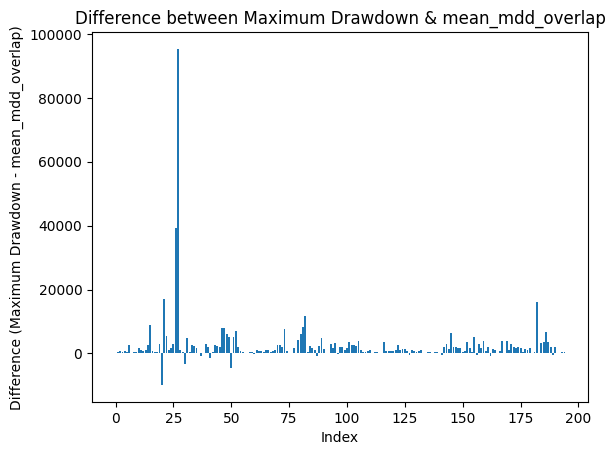

In [ ]:
# 두 열의 크기 차이 계산
difference =  result_df1['var95'] - result_df1['mdd1']

# 바 차트 그리기
plt.bar(result_df1.index, difference)

# 레이블링 및 제목 설정
plt.xlabel('Index')
plt.ylabel('Difference (Maximum Drawdown - mean_mdd_overlap)')
plt.title('Difference between Maximum Drawdown & mean_mdd_overlap')

# 그래프 출력
plt.show()

# Z5 7일

In [ ]:
#시장모형
# 빈리스트 생성

result_columns = ['DataName', 'EventDate', 'ResidualVariance', 'R_M_Bar', 'AAR0', 'AAR1', 'AAR5', 'AAR10', 'AAR25', 'CSAR0', 'CSAR1', 'CSAR5', 'CSAR10', 'CSAR25',
                  'shapiro_result','var95','var99','mdd5']
result_df5 = pd.DataFrame(columns=result_columns)

for data_path in csv_files:
    try:
        # 데이터불러오기
        df = pd.read_csv(data_path)

        # 일별 수익률 계산
        #df['daily_return'] = np.log(df['Close'])
        df['daily_return'] = df['Close'].diff()

        #누적수익률
        df['cum_return'] = df['daily_return'].cumsum()
        kospi['cum_return'] = kospi['r_m'].cumsum()

        # event_date 날짜형식으로
        date_str = data_path.split("_")[1].split(".")[0]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = date_obj.strftime('%Y-%m-%d')

         #  event_date이 거래일이 아닌 경우 가장 가까운날 랜덤하게 선택
        if event_date not in df['Date'].values:
            nearest_date_idx = (pd.to_datetime(df['Date']) - pd.to_datetime(event_date)).abs().idxmin()
            event_date = df.loc[nearest_date_idx-1, 'Date']

#         # event_date이 거래일이 아닌 경우 다음거래일을 event_date으로 선택
#         if event_date not in df['Date'].values:
#             future_dates = df[df['Date'] > event_date]['Date']
#             nearest_date = future_dates[pd.to_datetime(future_dates).sub(pd.to_datetime(event_date)).abs().idxmin()]
#             event_date = nearest_date


        # 이벤트 날짜의 인덱스 가져오기
        event_index = df[df['Date'] == event_date].index[0]
        post_event_df = df[event_index:]

        # new_date 열 추가
        df['new_date'] = df.index - event_index

#         #MDD 계산하기


#         #drawdowns
#         event_cum_return = df.loc[df['Date'] == event_date, 'cum_return'].iloc[0]
#         drawdowns = event_cum_return - post_event_df['cum_return']

#         # drawdown이 처음으로 음수가 되는 시점
#         first_negative_index = drawdowns.lt(0).idxmax()

#         # max drawdown
#         mdd = drawdowns.iloc[:first_negative_index-event_index+1].max()
#         mdd_index = drawdowns[:first_negative_index - event_index + 1].idxmax()


#         # mdd_time: max drawdown이 되는 시점까지의 시간
#         mdd_time = mdd_index - event_index

#         # recovery까지 시간 계산
#         time_to_recovery = first_negative_index - event_index
#       #time_to_recovery = 30

        #####overall mdd####


        df['r_i'] = calculate_mdds_over_recovery_time2(df['cum_return'], 7)
        kospi['r_mm'] = calculate_mdds_over_recovery_time2(kospi['cum_return'], 7)


        # new_date 열 추가
        df['new_date'] = df.index - event_index




        # 선택된 열 추출
        selected_kospi = kospi[['Date','r_mm']]
        selected_df = df[['Date','new_date','r_i']]

        # 날짜 형식 변환
        selected_df['Date'] = pd.to_datetime(selected_df['Date'])
        selected_kospi['Date'] = pd.to_datetime(selected_kospi['Date'])


        # 'kospi_날짜' 및 'Date' 열을 기준으로 조인
        merged_df = pd.merge(selected_df, selected_kospi, how='left', on='Date')


        #train period
        estpd_df = merged_df[(merged_df['new_date'] >= -100) & (merged_df['new_date'] <= -2)]
        #결측값 발생시 최근3개의 평균으로 대체
        #estpd_df['r_m'].fillna(estpd_df['r_m'].rolling(window=3, min_periods=1).mean(), inplace=True)
        #결측값 발생시 누락
        estpd_df = estpd_df.dropna()

        # 회귀분석을 위한 모델 생성
        X = estpd_df[['r_mm']]
        y = estpd_df['r_i']

        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_
        alpha = model.intercept_


        # 잔차(residuals) 추출
        residuals = y - model.predict(X)

        # 잔차의 분산 출력
        residual_variance = residuals.var()

        r_m_bar = estpd_df['r_mm'].mean()

        # 필요한 값 추출
        r_values = {}
        rm_values = {}
        rf_values = {}
        ar_values = {}
        var_ar_values = {}
        sar_values = {}

        for t in range(-1, 26):
            r_t = merged_df.loc[merged_df['new_date'] == t, 'r_i'].values[0]
            r_m_t = merged_df.loc[merged_df['new_date'] == t, 'r_mm'].values[0]
            ar_t = r_t - (alpha + beta * r_m_t)
            var_ar_t = residual_variance * (1 + 1/100 + (r_m_t - r_m_bar)**2 / ((estpd_df['r_mm'] - r_m_bar) ** 2).sum())
            sar_t = ar_t / np.sqrt(var_ar_t)
            r_values[f'r_{t:02d}'] = r_t
            rm_values[f'rm_{t:02d}'] = r_m_t
            ar_values[f'ar_{t:02d}'] = ar_t[0]
            var_ar_values[f'var_ar_{t:02d}'] = var_ar_t
            sar_values[f'sar_{t:02d}'] = sar_t[0]


        #CAR_i
        car0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))
        car1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))
        car5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))
        car10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))
        car25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))

        #AAR_i
        aar0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))/2
        aar1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))/3
        aar5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))/7
        aar10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))/12
        aar25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))/27

        #CSAR_i
        csar0 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 1))/np.sqrt(2)
        csar1 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 2))/np.sqrt(3)
        csar5 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 6))/np.sqrt(7)
        csar10 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 11))/np.sqrt(12)
        csar25 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 26))/np.sqrt(27)


        # Shapiro-Wilk 검정 수행
        statistic, p_value = shapiro(estpd_df['r_i'])

        # 결과를 저장하는 객체 생성
        shapiro_result = 1 if p_value > 0.05 else 0

        #VaR
        var95 = estpd_df['r_i'].quantile(0.95)
        var99 = estpd_df['r_i'].quantile(0.99)

        selected_rows = df[(df['new_date'] >= -2) & (df['new_date'] <= 5)]
        mdd5 = calculate_mdd(selected_rows['cum_return'].astype(float))


        #Append results to result_df
        result_df5 = result_df5.append({
             'DataName': os.path.basename(data_path),
             'EventDate': event_date,
             'ResidualVariance': residual_variance,
             'R_M_Bar': r_m_bar,
             'AAR0': aar0,
             'AAR1': aar1,
             'AAR5': aar5,
             'AAR10': aar10,
             'AAR25': aar25,
             'CSAR0': csar0,
             'CSAR1': csar1,
             'CSAR5': csar5,
             'CSAR10': csar10,
             'CSAR25': csar25,
            'shapiro_result': shapiro_result,
            'var95': var95,
            'var99': var99,
            'mdd7': mdd5
         }, ignore_index=True)
    except Exception as e:
        print(f"Error processing {data_path}: {e}")



Error processing kt.csv: 'Close'
Error processing log result.csv: 'Close'


In [ ]:
result_df = result_df5

In [ ]:
#검정통계량 계산
sum_csar = result_df['CSAR0'].sum()
n=len(result_df['CSAR0'])-result_df['CSAR0'].isna().sum()
total_csar = sum_csar/n
Z0=np.sqrt(n)*total_csar
print(f'Z0:',round(Z0,4))


#검정통계량 계산
sum_csar = result_df['CSAR1'].sum()
n=len(result_df['CSAR1'])-result_df['CSAR1'].isna().sum()
total_csar = sum_csar/n
Z1=np.sqrt(n)*total_csar
print(f'Z1:', round(Z1,4))

#검정통계량 계산
sum_csar = result_df['CSAR5'].sum()
n=len(result_df['CSAR5'])-result_df['CSAR5'].isna().sum()
total_csar = sum_csar/n
Z5=np.sqrt(n)*total_csar
print(f'Z5:',round(Z5,2))

#검정통계량 계산
sum_csar = result_df['CSAR10'].sum()
n=len(result_df['CSAR10'])-result_df['CSAR10'].isna().sum()
total_csar = sum_csar/n
Z10=np.sqrt(n)*total_csar
print(f'Z10:',round(Z10,4))

#검정통계량 계산
sum_csar = result_df['CSAR25'].sum()
n=len(result_df['CSAR25'])-result_df['CSAR25'].isna().sum()
total_csar = sum_csar/n
Z25=np.sqrt(n)*total_csar
print(f'Z25:',round(Z25,4))



Z0: 0.6201
Z1: 0.1029
Z5: 1.16
Z10: 2.2511
Z25: 3.9901


In [ ]:
result_df5['shapiro_result'].sum()

5

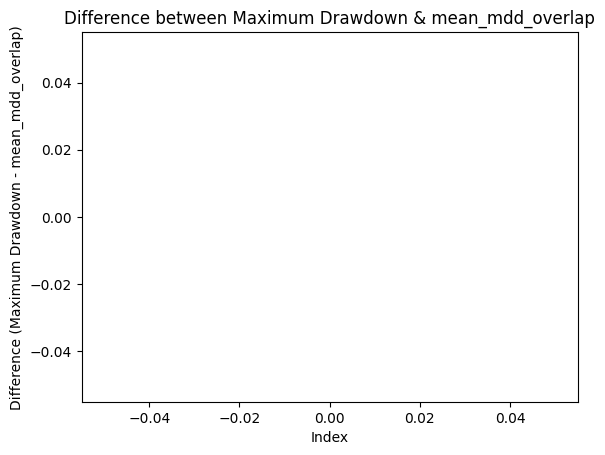

In [ ]:
# 두 열의 크기 차이 계산
difference =  result_df5['var95'] - result_df5['mdd5']

# 바 차트 그리기
plt.bar(result_df5.index, difference)

# 레이블링 및 제목 설정
plt.xlabel('Index')
plt.ylabel('Difference (Maximum Drawdown - mean_mdd_overlap)')
plt.title('Difference between Maximum Drawdown & mean_mdd_overlap')

# 그래프 출력
plt.show()

# Z10 12일

In [ ]:
#시장모형
# 빈리스트 생성

result_columns = ['DataName', 'EventDate', 'ResidualVariance', 'R_M_Bar', 'AAR0', 'AAR1', 'AAR5', 'AAR10', 'AAR25', 'CSAR0', 'CSAR1', 'CSAR5', 'CSAR10', 'CSAR25',
                  'shapiro_result','var95','var99','mdd10']
result_df10 = pd.DataFrame(columns=result_columns)

for data_path in csv_files:
    try:
        # 데이터불러오기
        df = pd.read_csv(data_path)

        # 일별 수익률 계산
        #df['daily_return'] = np.log(df['Close'])
        df['daily_return'] = df['Close'].diff()

        #누적수익률
        df['cum_return'] = df['daily_return'].cumsum()
        kospi['cum_return'] = kospi['r_m'].cumsum()

        # event_date 날짜형식으로
        date_str = data_path.split("_")[1].split(".")[0]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = date_obj.strftime('%Y-%m-%d')

         #  event_date이 거래일이 아닌 경우 가장 가까운날 랜덤하게 선택
        if event_date not in df['Date'].values:
            nearest_date_idx = (pd.to_datetime(df['Date']) - pd.to_datetime(event_date)).abs().idxmin()
            event_date = df.loc[nearest_date_idx-1, 'Date']

#         # event_date이 거래일이 아닌 경우 다음거래일을 event_date으로 선택
#         if event_date not in df['Date'].values:
#             future_dates = df[df['Date'] > event_date]['Date']
#             nearest_date = future_dates[pd.to_datetime(future_dates).sub(pd.to_datetime(event_date)).abs().idxmin()]
#             event_date = nearest_date


        # 이벤트 날짜의 인덱스 가져오기
        event_index = df[df['Date'] == event_date].index[0]
        post_event_df = df[event_index:]

        # new_date 열 추가
        df['new_date'] = df.index - event_index

        #MDD 계산하기


        #drawdowns
        event_cum_return = df.loc[df['Date'] == event_date, 'cum_return'].iloc[0]
        drawdowns = event_cum_return - post_event_df['cum_return']
        mdd12 = drawdowns.iloc[:12+1].max

#         # drawdown이 처음으로 음수가 되는 시점
#         first_negative_index = drawdowns.lt(0).idxmax()

#         # max drawdown
#         mdd = drawdowns.iloc[:first_negative_index-event_index+1].max()
#         mdd_index = drawdowns[:first_negative_index - event_index + 1].idxmax()

#         # mdd_time: max drawdown이 되는 시점까지의 시간
#         mdd_time = mdd_index - event_index

#         # recovery까지 시간 계산
#         time_to_recovery = first_negative_index - event_index
#         #time_to_recovery = 30


        #####overall mdd####


        df['r_i'] = calculate_mdds_over_recovery_time2(df['cum_return'], 12)
        kospi['r_mm'] = calculate_mdds_over_recovery_time2(kospi['cum_return'], 12)


        # new_date 열 추가
        df['new_date'] = df.index - event_index




        # 선택된 열 추출
        selected_kospi = kospi[['Date','r_mm']]
        selected_df = df[['Date','new_date','r_i']]

        # 날짜 형식 변환
        selected_df['Date'] = pd.to_datetime(selected_df['Date'])
        selected_kospi['Date'] = pd.to_datetime(selected_kospi['Date'])


        # 'kospi_날짜' 및 'Date' 열을 기준으로 조인
        merged_df = pd.merge(selected_df, selected_kospi, how='left', on='Date')


        #train period
        estpd_df = merged_df[(merged_df['new_date'] >= -100) & (merged_df['new_date'] <= -2)]
        #결측값 발생시 최근3개의 평균으로 대체
        #estpd_df['r_m'].fillna(estpd_df['r_m'].rolling(window=3, min_periods=1).mean(), inplace=True)
        #결측값 발생시 누락
        estpd_df = estpd_df.dropna()

        # 회귀분석을 위한 모델 생성
        X = estpd_df[['r_mm']]
        y = estpd_df['r_i']

        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_
        alpha = model.intercept_


        # 잔차(residuals) 추출
        residuals = y - model.predict(X)

        # 잔차의 분산 출력
        residual_variance = residuals.var()

        r_m_bar = estpd_df['r_mm'].mean()

        # 필요한 값 추출
        r_values = {}
        rm_values = {}
        rf_values = {}
        ar_values = {}
        var_ar_values = {}
        sar_values = {}

        for t in range(-1, 26):
            r_t = merged_df.loc[merged_df['new_date'] == t, 'r_i'].values[0]
            r_m_t = merged_df.loc[merged_df['new_date'] == t, 'r_mm'].values[0]
            ar_t = r_t - (alpha + beta * r_m_t)
            var_ar_t = residual_variance * (1 + 1/100 + (r_m_t - r_m_bar)**2 / ((estpd_df['r_mm'] - r_m_bar) ** 2).sum())
            sar_t = ar_t / np.sqrt(var_ar_t)
            r_values[f'r_{t:02d}'] = r_t
            rm_values[f'rm_{t:02d}'] = r_m_t
            ar_values[f'ar_{t:02d}'] = ar_t[0]
            var_ar_values[f'var_ar_{t:02d}'] = var_ar_t
            sar_values[f'sar_{t:02d}'] = sar_t[0]


        #CAR_i
        car0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))
        car1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))
        car5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))
        car10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))
        car25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))

        #AAR_i
        aar0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))/2
        aar1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))/3
        aar5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))/7
        aar10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))/12
        aar25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))/27

        #CSAR_i
        csar0 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 1))/np.sqrt(2)
        csar1 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 2))/np.sqrt(3)
        csar5 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 6))/np.sqrt(7)
        csar10 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 11))/np.sqrt(12)
        csar25 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 26))/np.sqrt(27)

        # Shapiro-Wilk 검정 수행
        statistic, p_value = shapiro(estpd_df['r_i'])

        # 결과를 저장하는 객체 생성
        shapiro_result = 1 if p_value > 0.05 else 0

        #VaR
        var95 = estpd_df['r_i'].quantile(0.95)
        var99 = estpd_df['r_i'].quantile(0.99)

        selected_rows = df[(df['new_date'] >= -2) & (df['new_date'] <= 10)]
        mdd10 = calculate_mdd(selected_rows['cum_return'].astype(float))



        #Append results to result_df
        result_df10 = result_df10.append({
             'DataName': os.path.basename(data_path),
             'EventDate': event_date,
             'ResidualVariance': residual_variance,
             'R_M_Bar': r_m_bar,
             'AAR0': aar0,
             'AAR1': aar1,
             'AAR5': aar5,
             'AAR10': aar10,
             'AAR25': aar25,
             'CSAR0': csar0,
             'CSAR1': csar1,
             'CSAR5': csar5,
             'CSAR10': csar10,
             'CSAR25': csar25,
            'shapiro_result': shapiro_result,
            'var95': var95,
            'var99': var99,
            'mdd10': mdd10
         }, ignore_index=True)
    except Exception as e:
        print(f"Error processing {data_path}: {e}")



Error processing kt.csv: 'Close'
Error processing log result.csv: 'Close'


In [ ]:
result_df = result_df10

In [ ]:
#검정통계량 계산
sum_csar = result_df['CSAR0'].sum()
n=len(result_df['CSAR0'])-result_df['CSAR0'].isna().sum()
total_csar = sum_csar/n
Z0=np.sqrt(n)*total_csar
print(f'Z0:',round(Z0,4))


#검정통계량 계산
sum_csar = result_df['CSAR1'].sum()
n=len(result_df['CSAR1'])-result_df['CSAR1'].isna().sum()
total_csar = sum_csar/n
Z1=np.sqrt(n)*total_csar
print(f'Z1:', round(Z1,4))

#검정통계량 계산
sum_csar = result_df['CSAR5'].sum()
n=len(result_df['CSAR5'])-result_df['CSAR5'].isna().sum()
total_csar = sum_csar/n
Z5=np.sqrt(n)*total_csar
print(f'Z5:',round(Z5,2))

#검정통계량 계산
sum_csar = result_df['CSAR10'].sum()
n=len(result_df['CSAR10'])-result_df['CSAR10'].isna().sum()
total_csar = sum_csar/n
Z10=np.sqrt(n)*total_csar
print(f'Z10:',round(Z10,4))

#검정통계량 계산
sum_csar = result_df['CSAR25'].sum()
n=len(result_df['CSAR25'])-result_df['CSAR25'].isna().sum()
total_csar = sum_csar/n
Z25=np.sqrt(n)*total_csar
print(f'Z25:',round(Z25,4))



Z0: 1.5562
Z1: 1.9508
Z5: 3.01
Z10: 5.5025
Z25: 9.4112


In [ ]:
result_df10['shapiro_result'].sum()

3

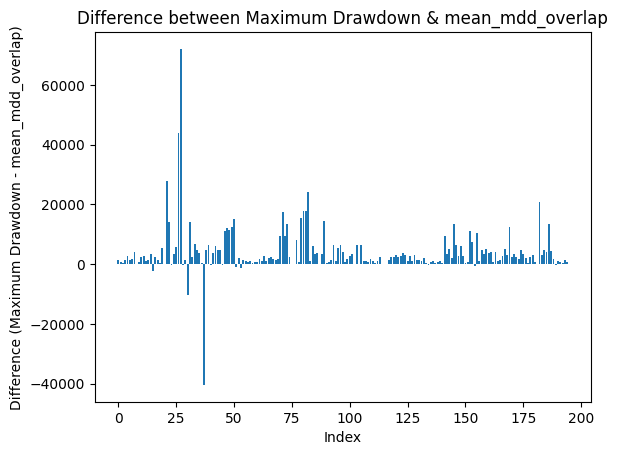

In [ ]:
# 두 열의 크기 차이 계산
difference =  result_df10['var95'] - result_df10['mdd10']

# 바 차트 그리기
plt.bar(result_df10.index, difference)

# 레이블링 및 제목 설정
plt.xlabel('Index')
plt.ylabel('Difference (Maximum Drawdown - mean_mdd_overlap)')
plt.title('Difference between Maximum Drawdown & mean_mdd_overlap')

# 그래프 출력
plt.show()

# Z25 27일

In [ ]:
#시장모형
# 빈리스트 생성

result_columns = ['DataName', 'EventDate', 'ResidualVariance', 'R_M_Bar', 'AAR0', 'AAR1', 'AAR5', 'AAR10', 'AAR25', 'CSAR0', 'CSAR1', 'CSAR5', 'CSAR10', 'CSAR25',
                 'shapiro_result', 'var95', 'var99', 'mdd25']
result_df25 = pd.DataFrame(columns=result_columns)

for data_path in csv_files:
    try:
        # 데이터불러오기
        df = pd.read_csv(data_path)

        # 일별 수익률 계산
        #df['daily_return'] = np.log(df['Close'])
        df['daily_return'] = df['Close'].diff()

        #누적수익률
        df['cum_return'] = df['daily_return'].cumsum()
        kospi['cum_return'] = kospi['r_m'].cumsum()

        # event_date 날짜형식으로
        date_str = data_path.split("_")[1].split(".")[0]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        event_date = date_obj.strftime('%Y-%m-%d')

         #  event_date이 거래일이 아닌 경우 가장 가까운날 랜덤하게 선택
        if event_date not in df['Date'].values:
            nearest_date_idx = (pd.to_datetime(df['Date']) - pd.to_datetime(event_date)).abs().idxmin()
            event_date = df.loc[nearest_date_idx-1, 'Date']

#         # event_date이 거래일이 아닌 경우 다음거래일을 event_date으로 선택
#         if event_date not in df['Date'].values:
#             future_dates = df[df['Date'] > event_date]['Date']
#             nearest_date = future_dates[pd.to_datetime(future_dates).sub(pd.to_datetime(event_date)).abs().idxmin()]
#             event_date = nearest_date


        # 이벤트 날짜의 인덱스 가져오기
        event_index = df[df['Date'] == event_date].index[0]
        post_event_df = df[event_index:]

        # new_date 열 추가
        df['new_date'] = df.index - event_index

#         #MDD 계산하기


#         #drawdowns
#         event_cum_return = df.loc[df['Date'] == event_date, 'cum_return'].iloc[0]
#         drawdowns = event_cum_return - post_event_df['cum_return']

#         # drawdown이 처음으로 음수가 되는 시점
#         first_negative_index = drawdowns.lt(0).idxmax()

#         # max drawdown
#         mdd = drawdowns.iloc[:first_negative_index-event_index+1].max()
#         mdd_index = drawdowns[:first_negative_index - event_index + 1].idxmax()

#         # mdd_time: max drawdown이 되는 시점까지의 시간
#         mdd_time = mdd_index - event_index

#         # recovery까지 시간 계산
#         time_to_recovery = first_negative_index - event_index
#         #time_to_recovery = 30

        #####overall mdd####


        df['r_i'] = calculate_mdds_over_recovery_time2(df['cum_return'], 27)
        kospi['r_mm'] = calculate_mdds_over_recovery_time2(kospi['cum_return'], 27)


        # new_date 열 추가
        df['new_date'] = df.index - event_index




        # 선택된 열 추출
        selected_kospi = kospi[['Date','r_mm']]
        selected_df = df[['Date','new_date','r_i']]

        # 날짜 형식 변환
        selected_df['Date'] = pd.to_datetime(selected_df['Date'])
        selected_kospi['Date'] = pd.to_datetime(selected_kospi['Date'])


        # 'kospi_날짜' 및 'Date' 열을 기준으로 조인
        merged_df = pd.merge(selected_df, selected_kospi, how='left', on='Date')


        #train period
        estpd_df = merged_df[(merged_df['new_date'] >= -100) & (merged_df['new_date'] <= -2)]
        #결측값 발생시 최근3개의 평균으로 대체
        #estpd_df['r_m'].fillna(estpd_df['r_m'].rolling(window=3, min_periods=1).mean(), inplace=True)
        #결측값 발생시 누락
        estpd_df = estpd_df.dropna()

        # 회귀분석을 위한 모델 생성
        X = estpd_df[['r_mm']]
        y = estpd_df['r_i']

        # 선형 회귀 모델 생성 및 학습
        model = LinearRegression()
        model.fit(X, y)

        beta = model.coef_
        alpha = model.intercept_


        # 잔차(residuals) 추출
        residuals = y - model.predict(X)

        # 잔차의 분산 출력
        residual_variance = residuals.var()

        r_m_bar = estpd_df['r_mm'].mean()

        # 필요한 값 추출
        r_values = {}
        rm_values = {}
        rf_values = {}
        ar_values = {}
        var_ar_values = {}
        sar_values = {}

        for t in range(-1, 26):
            r_t = merged_df.loc[merged_df['new_date'] == t, 'r_i'].values[0]
            r_m_t = merged_df.loc[merged_df['new_date'] == t, 'r_mm'].values[0]
            ar_t = r_t - (alpha + beta * r_m_t)
            var_ar_t = residual_variance * (1 + 1/100 + (r_m_t - r_m_bar)**2 / ((estpd_df['r_mm'] - r_m_bar) ** 2).sum())
            sar_t = ar_t / np.sqrt(var_ar_t)
            r_values[f'r_{t:02d}'] = r_t
            rm_values[f'rm_{t:02d}'] = r_m_t
            ar_values[f'ar_{t:02d}'] = ar_t[0]
            var_ar_values[f'var_ar_{t:02d}'] = var_ar_t
            sar_values[f'sar_{t:02d}'] = sar_t[0]


        #CAR_i
        car0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))
        car1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))
        car5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))
        car10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))
        car25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))

        #AAR_i
        aar0 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 1))/2
        aar1 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 2))/3
        aar5 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 6))/7
        aar10 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 11))/12
        aar25 = sum(ar_values[f'ar_{i:02d}' ] for i in range(-1, 26))/27

        #CSAR_i
        csar0 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 1))/np.sqrt(2)
        csar1 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 2))/np.sqrt(3)
        csar5 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 6))/np.sqrt(7)
        csar10 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 11))/np.sqrt(12)
        csar25 = sum(sar_values[f'sar_{i:02d}' ] for i in range(-1, 26))/np.sqrt(27)

        # Shapiro-Wilk 검정 수행
        statistic, p_value = shapiro(estpd_df['r_i'])

        # 결과를 저장하는 객체 생성
        shapiro_result = 1 if p_value > 0.05 else 0

        #VaR
        var95 = estpd_df['r_i'].quantile(0.95)
        var99 = estpd_df['r_i'].quantile(0.99)

        selected_rows = df[(df['new_date'] >= -2) & (df['new_date'] <= 25)]
        mdd25 = calculate_mdd(selected_rows['cum_return'].astype(float))


        #Append results to result_df
        result_df25 = result_df25.append({
             'DataName': os.path.basename(data_path),
             'EventDate': event_date,
             'ResidualVariance': residual_variance,
             'R_M_Bar': r_m_bar,
             'AAR0': aar0,
             'AAR1': aar1,
             'AAR5': aar5,
             'AAR10': aar10,
             'AAR25': aar25,
             'CSAR0': csar0,
             'CSAR1': csar1,
             'CSAR5': csar5,
             'CSAR10': csar10,
             'CSAR25': csar25,
             'shapiro_result': shapiro_result,
             'var95': var95,
             'var99': var99,
             'mdd25': mdd25
         }, ignore_index=True)
    except Exception as e:
        print(f"Error processing {data_path}: {e}")



Error processing kt.csv: 'Close'
Error processing log result.csv: 'Close'


In [ ]:
resultd_df = result_df25

In [ ]:
#검정통계량 계산
sum_csar = result_df['CSAR0'].sum()
n=len(result_df['CSAR0'])-result_df['CSAR0'].isna().sum()
total_csar = sum_csar/n
Z0=np.sqrt(n)*total_csar
print(f'Z0:',round(Z0,4))


#검정통계량 계산
sum_csar = result_df['CSAR1'].sum()
n=len(result_df['CSAR1'])-result_df['CSAR1'].isna().sum()
total_csar = sum_csar/n
Z1=np.sqrt(n)*total_csar
print(f'Z1:', round(Z1,4))

#검정통계량 계산
sum_csar = result_df['CSAR5'].sum()
n=len(result_df['CSAR5'])-result_df['CSAR5'].isna().sum()
total_csar = sum_csar/n
Z5=np.sqrt(n)*total_csar
print(f'Z5:',round(Z5,2))

#검정통계량 계산
sum_csar = result_df['CSAR10'].sum()
n=len(result_df['CSAR10'])-result_df['CSAR10'].isna().sum()
total_csar = sum_csar/n
Z10=np.sqrt(n)*total_csar
print(f'Z10:',round(Z10,4))

#검정통계량 계산
sum_csar = result_df['CSAR25'].sum()
n=len(result_df['CSAR25'])-result_df['CSAR25'].isna().sum()
total_csar = sum_csar/n
Z25=np.sqrt(n)*total_csar
print(f'Z25:',round(Z25,4))



Z0: 1.5562
Z1: 1.9508
Z5: 3.01
Z10: 5.5025
Z25: 9.4112


In [ ]:
result_df25['shapiro_result'].sum()

1

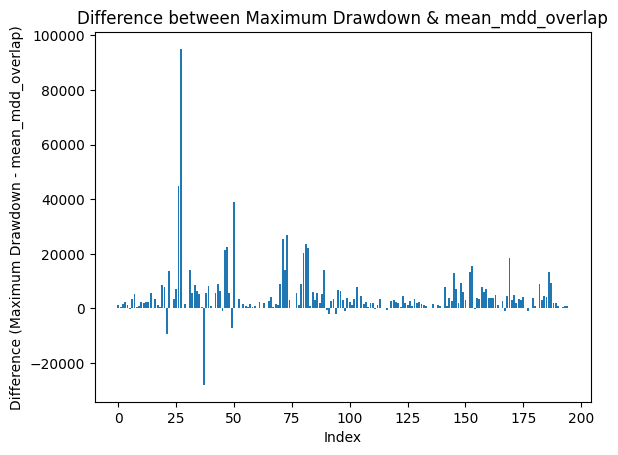

In [ ]:
# 두 열의 크기 차이 계산
difference =  result_df25['var95'] - result_df25['mdd25']

# 바 차트 그리기
plt.bar(result_df25.index, difference)

# 레이블링 및 제목 설정
plt.xlabel('Index')
plt.ylabel('Difference (Maximum Drawdown - mean_mdd_overlap)')
plt.title('Difference between Maximum Drawdown & mean_mdd_overlap')

# 그래프 출력
plt.show()